## COGS 108 - Final Project

### Important
- ONE, and only one, member of your group should upload this notebook to TritonED.
- Each member of the group will receive the same grade on this assignment.
- Keep the file name the same: submit the file 'FinalProject.ipynb'.
- Only upload the .ipynb file to TED, do not upload any associted data. Make sure that 
  for cells in which you want graders to see output that these cells have been executed.

### Group Members: Fill in the Student IDs of each group member here
Replace the lines below to list each persons full student ID, ucsd email and full name.

- A11600930, dhannani@ucsd.edu, Daniel Hannani
- A14218619, clohrli@ucsd.edu, Chad Lohrli
- A14254947, vzadeh@ucsd.edu, Vala Zadeh


### Introduction
As students at the university level, there are two things that concern us most: getting a good GPA, and taking courses that will benefit us not only in our academic career but in our future careers as well. There are many factors that affect both of these concerns, and of these factors there are some that can be directly controlled, such as choosing well rounded professors and courses that are engaging to students. RateMyProfessor.com (RMP) and CAPES are two resources that provide student written reviews and statistics regarding courses and professors teaching at UCSD. Realizing that both of these resources are very rich in data, we decided to base our research on analyzing both of these resources to see if we could observe correlations between both datasets. 

Our hypothesis follows that RateMyProfessor reviews and comments will more likely contain polarized reviews whereas CAPE reviews with be more normally distributed. To reason about this hypothesis, CAPE reviews are internal to UCSD and professors incentivize students to complete them. In addition, UCSD sends frequent emails towards the end of the quarter reminding students to write reviews, therefore we can conclude a relatively high probability of students will write reviews (not mentioning potential confounding variables that can affect this statistic). RMP on the otherhand is a third party resource that is used nation wide and there is no explicit incentive to write reviews, therefore we believe that students who do go on RMP to write reviews are much more passionate about their reviews and will either write highly postive or highly negative reviews based on their experiences. 

A large portion of our project involves actually scraping all of the data from both of these sites, which is not a trivial task as both contain massive datasets and CAPES requires authentication to access reviews. To make our analysis more interesing, we have decided to augment our datasets by adding gender to each professor (using a name to gender model) in addition to average sentiment of each professor (by performing sentiment analysis on each professor's comments on RMP). Lastly, to be able to perform correlations on the datasets we need to combine both datasets into one dataframe containing the intersection of data from both datasets. Since CAPES contains all professors at UCSD and RMP does not necessarily have reviews for each professor, we use the unique teacher identifier (tid) from RMP and the professors first and last name to extract only the professors on RMP from CAPES. Once again combining the two datasets is not a trivial task as each row in the scraped CAPES dataset corresponds to one class with n number of reviews, where n is the number of evaluations for that professor, whereas each row in the RMP datasets corresponds to an individual review for that professor. Each row in our final dataframe will correspond to one unique professor, and therefore adding professors from the CAPES dataframe involves weighting each review feature (average gpa, reccommend instructor, etc.) by the fraction of evaluations made for that class.

Lastly, due to the large number of features and correlations of our final dataframe, there is no way we can possibly analyze each feature in depth given the amount of time given. Therefore we have chosen to specifically analyze the follwing correlations: average grades correlated to number of evaluations, average grades correlated to gender, and sentiment values correlated to gender. 

#### Imports
Below are specific third-party libraries we will be using

In [1]:
import sys
!{sys.executable} -m pip install textblob
!{sys.executable} -m pip install gender-guesser
!{sys.executable} -m pip install selenium
!{sys.executable} -m pip install pillow
!{sys.executable} -m pip install wordcloud

In [2]:
import requests
import json
import math
import re
import os
import json
import getpass
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import patsy
import time
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
from random import *
%matplotlib inline

##These Dependencies Need To be Downloaded
from textblob import TextBlob 
import gender_guesser.detector as gender
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

ModuleNotFoundError: No module named 'wordcloud'

### Rate My Professor (RMP) Scraping
#### Scraping Rate My Professor for All UCSD Professors
To scrape data from RMP we first need to figure out the GET request URL's that happen in the background when we use the site. Once we have those, we can get a list of all professors at UCSD <em>getProfessorList</em> and extract the ids of those professors. Using the teacher ids(tids) we can then query all the reviews for that professor <em>getProfessorInformation</em> and save it to a dataframe. <em>generateAllProfInformation</em> does this for all professors and save it to a dataframe along with some extra professor metadata that was returned with the list of all professors

In [7]:
def getProfessorList(schoolID):
    page_id = 1
    professorList = []
    while True:
        page = requests.get("http://www.ratemyprofessors.com/filter/professor/?&page=" 
                            + str(page_id) + "&filter=teacherlastname_sort_s+asc&query=*%3A*&queryoption=TEACHER&queryBy=schoolId&sid=" 
                            + str(schoolID))
        
        jsonpage = json.loads(page.content)
        professors = jsonpage['professors']
        professorList.extend(professors)
        
        if(int(jsonpage['remaining']) == 0):
            break
        else:
            page_id += 1
             
    
    df = pd.DataFrame(professorList)
    df = df.drop(df[df['tNumRatings'] == 0].index) #drop rows without responses
    df.to_json('professors.json')

    '''
    #save to json file
    with open('professors.json', 'w') as outfile:
        json.dump(professorList, outfile)
    '''
    
    return df
    
def getProfessorInformation(tid):
    page_id=1
    pages = []
    while True:
        url = 'http://www.ratemyprofessors.com/paginate/professors/ratings?tid='+ str(tid)+'&filter=&courseCode=&page='+str(page_id)
        page = requests.get(url);
        r_json = json.loads(page.content)
        #page_of_comments = pd.DataFrame.from_dict(r_json['ratings'], orient='columns')
        pages.extend(r_json['ratings'])
        
        if(int(r_json['remaining']) == 0):
            break
        else:
            page_id += 1
        
    df = pd.DataFrame(pages)
    prof = df_professors.loc[df_professors['tid'] == tid]
    df.insert(0,'tDept',prof['tDept'].values[0])
    df.insert(0,'tFname',prof['tFname'].values[0])
    df.insert(0,'tLname',prof['tLname'].values[0])
    df.insert(0,'tid',tid)
    
    return df

def generateAllProfInformation():
    data = []
    tids = df_professors['tid'].values
    
    for i in tids:
        data.append(getProfessorInformation(i))
    
    data = pd.concat(data)
    data.to_csv("profData.csv",index=False)
    
    return data

#### First We Grab All The Professors Metadata

In [4]:
ucsdID = 1079
df_professors = getProfessorList(ucsdID)

#### Next We Scrape All of Their Reviews
** Note This Will Take A While (~11mins on i7 2.9GHz)

In [8]:
df_responses = generateAllProfInformation()

Let's make sure our data saved properly

In [30]:
df_responses = pd.read_csv(open('profData.csv'), header=0)
df_responses.head()

,tid,tLname,tFname,tDept,attendance,clarityColor,easyColor,helpColor,helpCount,id,...,rStatus,rTextBookUse,rWouldTakeAgain,sId,takenForCredit,teacher,teacherGrade,teacherRatingTags,unUsefulGrouping,usefulGrouping
0,2325936,Aamari,Eddie,Mathematics,Not Mandatory,good,good,good,4.0,30218337.0,...,1.0,Yes,Yes,1079.0,Yes,NaN,NaN,"['Lecture heavy', 'Caring', 'Lots of homework']",people,people
1,2325936,Aamari,Eddie,Mathematics,Not Mandatory,good,average,good,3.0,29721878.0,...,1.0,Yes,Yes,1079.0,Yes,NaN,NaN,"['Hilarious', 'Caring', 'Lots of homework']",people,people
2,2325936,Aamari,Eddie,Mathematics,Not Mandatory,average,good,average,1.0,29701355.0,...,1.0,Yes,Yes,1079.0,Yes,NaN,NaN,"['Lecture heavy', 'Accessible outside class', ...",people,person
3,2325936,Aamari,Eddie,Mathematics,Not Mandatory,average,good,average,0.0,29682099.0,...,1.0,Yes,No,1079.0,Yes,NaN,NaN,[],person,people
4,2325936,Aamari,Eddie,Mathematics,Not Mandatory,good,average,good,8.0,29557088.0,...,1.0,Yes,Yes,1079.0,Yes,NaN,Not sure yet,"['Hilarious', 'Caring', 'Lots of homework']",people,people


### Now Let's Augment this Data for Better Analysis
#### Adding Gender
Since Rate My Professor doesn't provide any information on gender, we needed to way to obtain the gender some other way. Fortunately we do have name data, and for the most part we an deduce gender from common names. With this intuition we found a python model that does exactly this and the following code attempts to classify a professor by gender using their first name

#### Create id to gender dict

In [31]:
names = df_professors['tFname'].values
tids = df_professors['tid'].values

gender_model = gender.Detector(case_sensitive=False)
genders = {}
u = 0

for i,v in enumerate(names):
    name = v.split(' ')[0]
    g = gender_model.get_gender(name)
    if g == 'male' or g == 'mostly_male':
        genders[tids[i]] = 'M'
    elif g == 'female' or g =='mostly_female':
        genders[tids[i]] = 'F'
    elif g == 'unknown' or g == 'andy':
        genders[tids[i]] = 'U'
        u+=1

** An important note is that the gender data produced is only as good as the model, and we are aware that this may affect our overall analysis

#### Add genders to dataframe

In [32]:
# insert dummy column
df_responses.insert(4,'gender','M')

In [33]:
for k,v in genders.items():
    index = df_responses[df_responses['tid'] == str(k)].index
    df_responses.loc[index,'gender'] = v

Let's check to see if genders have been added. At a glance it looks good and we can confirm that "Eddie" is a male name which is what our model predicted

In [34]:
df_responses.head()

,tid,tLname,tFname,tDept,gender,attendance,clarityColor,easyColor,helpColor,helpCount,...,rStatus,rTextBookUse,rWouldTakeAgain,sId,takenForCredit,teacher,teacherGrade,teacherRatingTags,unUsefulGrouping,usefulGrouping
0,2325936,Aamari,Eddie,Mathematics,M,Not Mandatory,good,good,good,4.0,...,1.0,Yes,Yes,1079.0,Yes,NaN,NaN,"['Lecture heavy', 'Caring', 'Lots of homework']",people,people
1,2325936,Aamari,Eddie,Mathematics,M,Not Mandatory,good,average,good,3.0,...,1.0,Yes,Yes,1079.0,Yes,NaN,NaN,"['Hilarious', 'Caring', 'Lots of homework']",people,people
2,2325936,Aamari,Eddie,Mathematics,M,Not Mandatory,average,good,average,1.0,...,1.0,Yes,Yes,1079.0,Yes,NaN,NaN,"['Lecture heavy', 'Accessible outside class', ...",people,person
3,2325936,Aamari,Eddie,Mathematics,M,Not Mandatory,average,good,average,0.0,...,1.0,Yes,No,1079.0,Yes,NaN,NaN,[],person,people
4,2325936,Aamari,Eddie,Mathematics,M,Not Mandatory,good,average,good,8.0,...,1.0,Yes,Yes,1079.0,Yes,NaN,Not sure yet,"['Hilarious', 'Caring', 'Lots of homework']",people,people


#### Getting Sentiment from RMP Comments
The majority of the data from RMP comes in the form of comments, which are just long strings. To be able to analyze this data numerically, we obtained the sentiment value of each comment. To do this we used a common python model TextBlob, which allowed us to simply plug in comments to generate sentiments.

Comments are generally dirty, containing punctuation and numbers which doesn't help in determining sentiment. The following functions cleans up the comments

In [35]:
def clean_comment(comment): 
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", comment).split()) 

The sentiment values take on values between -1 and 1, which refer to negative and positive sentiments, respectively

In [36]:
def get_comment_sentiment(comment): 
    analysis = TextBlob(clean_comment(comment)) 
    # set sentiment 
    if analysis.sentiment.polarity > 0: 
        return 'positive', analysis.sentiment.polarity
    elif analysis.sentiment.polarity == 0: 
        return 'neutral', analysis.sentiment.polarity
    else: 
        return 'negative', analysis.sentiment.polarity

In [37]:
# insert dummy columns
df_responses.insert(18,'sentimentValue',0)
df_responses.insert(18,'sentiment','positive')

** Generating sentiments may take a while 

In [38]:
for i in df_responses.index:
    comment = df_responses.loc[i,'rComments']
    if(not pd.isna(comment)):
        sentiment,polarity = get_comment_sentiment(comment)
        df_responses.loc[i,'sentiment'] = sentiment
        df_responses.loc[i,'sentimentValue'] = polarity
    else:
        df_responses.loc[i,'sentiment'] = 'N/A'
        df_responses.loc[i,'sentimentValue'] = 0

Let's check out a random comment it's corresponding sentiment value

In [54]:
rand = randint(1, len(df_responses)-1)    # Pick a random number between 1 and 100.
display(df_responses['rComments'][rand])
display(df_responses['sentiment'][rand])
display(df_responses['sentimentValue'][rand])

'Really good teacher, lectures are dry but important for midterms and finals. He has a good sense of humor and is obssesed with pirates, which is his topic of research. Reading assignments are easy too.'

'positive'

0.4333333333333333

#### Sentiment values look good, let's keep moving!

** An important note is that the sentiment data produced is only as good as the model, and we are aware that this may affect our overall analysis

#### Now that we have some useful data, let's clean up what we don't need and standardize the columns we want to keep
 Remove Columns that are not Useful

In [55]:
dropColumns = ['rOverallString', 'onlineClass', 'rErrorMsg', 'rStatus', 'teacher', 'unUsefulGrouping', 'usefulGrouping', 'easyColor', 'helpColor', 'clarityColor']
df_responses.drop(columns=dropColumns,inplace=True)

Standardize Useful Columns

In [56]:
def yesNoToInt(str_in):
    if(str_in == "Yes"):
        return 1
    elif (str_in == "No"):
        return 0
    return str_in

In [57]:
def letterToGPA(str_in):
    gpaDict = {
        'A+': 4.0,
        'A' : 4.0,
        'A-': 3.7,
        'B+': 3.3,
        'B' : 3.0,
        'B-': 2.7,
        'C+': 2.3,
        'C' : 2.0,
        'C-': 1.7,
        'D+': 1.3,
        'D' : 1.0,
        'D-': 0.7,
        'F' : 0.0
    }
    return gpaDict.get(str_in, np.nan)

In [58]:
def interestToInt(str_in):
    if(str_in == "Low"):
        return 1
    elif (str_in == "Meh"):
        return 2
    elif (str_in == "Sorta interested"):
        return 3
    elif (str_in == "Really into it"):
        return 4
    elif (str_in == "It's my life"):
        return 5
    return str_in

In [59]:
def genderToInt(str_in):
    if(str_in == 'M'):
        return 1
    elif(str_in == 'F'):
        return -1
    else:
        return np.nan

In [60]:
df_responses["rTextBookUse"] = df_responses["rTextBookUse"].apply(yesNoToInt)
df_responses["rWouldTakeAgain"] = df_responses["rWouldTakeAgain"].apply(yesNoToInt)
df_responses["takenForCredit"] = df_responses["takenForCredit"].apply(yesNoToInt)
df_responses["rInterest"] = df_responses["rInterest"].apply(interestToInt)
df_responses["gender"] = df_responses["gender"].apply(genderToInt)
df_responses["teacherGrade"] = df_responses["teacherGrade"].apply(letterToGPA)

Intermediate save to be safe

In [61]:
df_responses.to_csv("modifiedProfInfo.csv", index=False)

### Let's have a little fun with our new dataset Before Moving On
#### We're going to generate a wordcloud of all the comments in RMP

In [62]:
text = " ".join(comment for comment in df_responses.rComments if pd.notnull(comment))

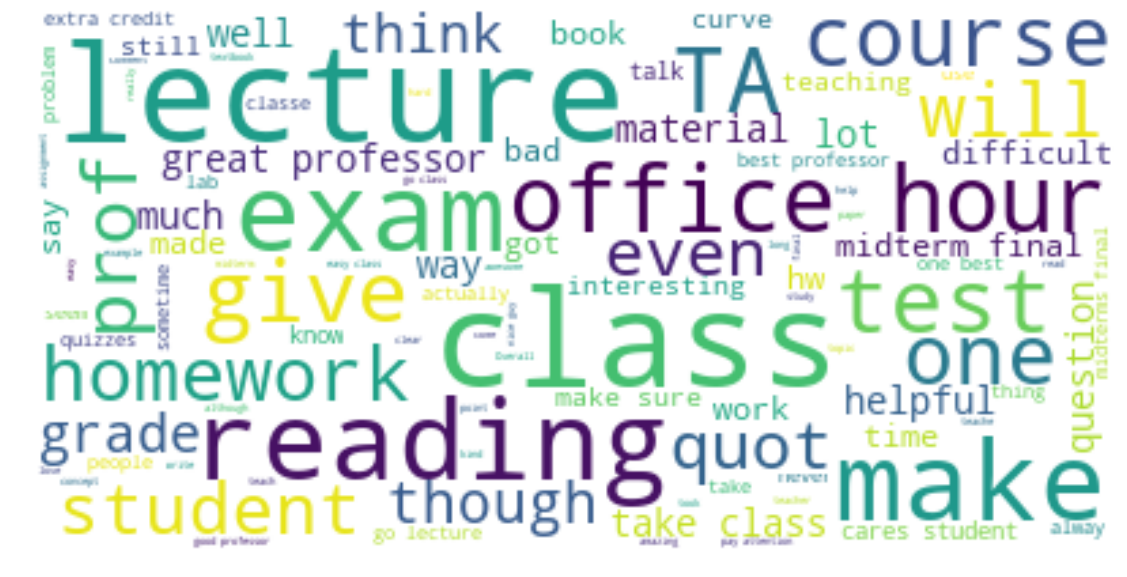

In [63]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=50, max_words=100,stopwords=stopwords, background_color="white").generate(text)

plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### CAPES Scraping
##### Instructions : Download Appropriate Web Driver from the ChromeDrivers folder and add the Executeable to Path
https://chromedriver.storage.googleapis.com/index.html?path=74.0.3729.6/

** Note if you are having issues adding driver to your executable path, you can pass in the path directly e.g.

#### webdriver.Chrome('/insert/path/here/chromedriver')

Scraping data from CAPES is much more tedious than RMP due to the fact that CAPES data is only accessible to UCSD students. For this reason we need to actually perform an automated login to get to the data. We used Selenium and a Chrome Driver to programically login to capes

#### Let's Login To Capes
The following codes requires you to input a username, and will provide a secure input field for password when run. The code then opens up a Google Chrome browser and performs an automated login to CAPES.

** Don't worry, the password is protected and erased as soon as the cell finishes running or if potentially crashes

In [65]:
#enter credentials
username = 'clohrli'
password = getpass.getpass()


if(len(username) < 1):
    assert len(username) > 0
    
if(len(password) < 1):  
    password = '' #safety
    assert len(password) > 0

#init chrome driver, you may need to actually pass the path in
# e.g. webdriver.Chrome('/insert/path/here/chromedriver')
driver = webdriver.Chrome()
driver.get("https://cape.ucsd.edu/responses/Results.aspx")

#fill in username
elem = driver.find_element_by_name("urn:mace:ucsd.edu:sso:username")
elem.clear()
elem.send_keys(username)

#fill in password
elem = driver.find_element_by_name("urn:mace:ucsd.edu:sso:password")
elem.clear()
elem.send_keys(password)

#login!
elem = driver.find_element_by_name("_eventId_proceed").click()

#reset username & password for safety
username = ''
password = ''

········


** Make sure to keep the google drive window open during the rest of the process

#### Get all the Departments
To be able to query into capes, we need all the department names. Thanfully Selenium has a method to select from the dropdown menu that provides all the deparment names

In [66]:
select = Select(driver.find_element_by_name('ctl00$ContentPlaceHolder1$ddlDepartments'))
options = select.options
del options[0] #remove "select department tag"
departments = [o.get_attribute('value') for o in options]

#### Download All Page Sources For Each Department
Using Selenium we download all the webpages source files for each department so that we can use beautiful soup to parse them. Notice we needed to add a timeout since each query has a loading time in CAPES

In [70]:
basecape = 'http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber='
page_sources = []
for depts in departments:
    req = basecape + depts
    driver.get(req)
    time.sleep(1)
    page_sources.append(driver.page_source)

#### Build Headers For DataFrame
This function builds all the table headers which describe each column in the CAPES tables.

In [72]:
headers = []
soup = BeautifulSoup(page_sources[0], 'html.parser')
table = soup.find('table', attrs={'class':'styled'})
for th in table.find('tr').findAll('th'):
    headers.append(th.text.strip())

The headers describe the features of the CAPE dataset

In [73]:
headers

['Instructor',
 'Course',
 'Term',
 'Enroll',
 'Evals Made',
 'Rcmnd Class',
 'Rcmnd Instr',
 'Study Hrs/wk',
 'Avg Grade Expected',
 'Avg Grade Received']

#### Parse Table Containing Reviews Into DataFrame
Now looping through each page source, we use beautiful soup to extract all the data for each department table into a dataframe

In [74]:
dataframes = []
for source in page_sources:
    soup = BeautifulSoup(source, 'html.parser')
    table = soup.find('table', attrs={'class':'styled'})
    data = []
    for i,row in enumerate(table.findAll('tr')):
        if i==0:
            continue
        else:
            col_data = []
            for td in row.findAll('td'): 
                col_data.append(td.text.strip())
        data.append(col_data)
    dataframes.append(pd.DataFrame(data))

#### Concat DataFrame, Add Headers


In [89]:
df = pd.concat(dataframes)
df.columns = headers
df.reset_index(drop=True,inplace=True)

Let's see what we got!

In [90]:
df.head()

,Instructor,Course,Term,Enroll,Evals Made,Rcmnd Class,Rcmnd Instr,Study Hrs/wk,Avg Grade Expected,Avg Grade Received
0,"Goldstein, Paul S",ANTH 101 - Foundations/Social Complexity (A),FA18,137,73,81.2 %,79.1 %,4.00,B+ (3.33),B+ (3.35)
1,"Semendeferi, Ekaterini",ANTH 196A - Honors Studies in Anthropology (A),FA18,13,4,100.0 %,100.0 %,7.00,A (4.00),N/A
2,"Rothschild, Amy C",ANTH 21 - Race and Racisms (A),FA18,212,96,94.7 %,97.8 %,3.01,B+ (3.58),B+ (3.54)
3,"Kang, Byung Chu",ANTH 21 - Race and Racisms (B),FA18,314,214,94.2 %,93.7 %,3.36,A- (3.82),A- (3.73)
4,"Stewart, Alexander B",ANTH 23 - Debating Multiculturalism (A),FA18,407,351,87.9 %,95.6 %,3.53,B+ (3.58),B+ (3.42)


Intermediate save to be safe

In [91]:
df.to_csv('capeReviews.csv',index=False)

In [126]:
df = pd.read_csv(open('capeReviews.csv'), header=0)

#### Standardizing Columns

Replacing percent with decimal float values

In [127]:
def cleanPercentage(percent):
    percent = percent.strip()
    percent = percent.split(' ')[0]
    percent = float(percent) / 100.0
    return percent

Replacing letter grades with purely numerical values for analysis

In [128]:
def cleanGrades(grades):
    if(pd.notnull(grades)):
        grades.strip()
        grades = grades.split(' ')[1]
        grades = grades.strip('()')
        return float(grades)
    else:
        return grades

Here we encode the terms by quarter and year so that we can perform time series analysis further on

e.g. FA19 = 193, WI07 = 70

In [129]:
def cleanTerms(terms):
    semester = terms[:2]
    year     = terms[2:4]
    
    if(semester == "WI"):
        return (int)(year+"0")
    
    if(semester == "SP"):
        return (int)(year+"1")
    
    if(semester == "S1" or semester == "S2" or semester == "S3" or semester == "SU"):
        return (int)(year+"2")
    
    if(semester == "FA"):
        return (int)(year+"3")
    

#### The following functions are used to make it possible to combine both RMP and CAPES datasets into one dataframe

We extract the department name from the course description since RMP only has reliable department data

In [130]:
def splitDepartment(course):
    course = course.strip()
    course = course.split(" ")[0]
    return course

We need to split professors names into first and last to match the convention in RMP

In [131]:
def splitFirstName(inst):
    if(pd.notnull(inst)):
        inst = inst.strip()
        inst = inst.split(",")[1].strip()
        inst = inst.split(" ")[0].strip()
        return inst
    else:
        return inst

In [132]:
def splitLastName(inst):
    if(pd.notnull(inst)):
        inst = inst.strip()
        inst = inst.split(",")[0].strip()
        return inst
    else:
        return inst

### Eval / Enroll
You will notice we are using Eval / Enroll as one of the augmented columns. This is because the relationship between these two values is what we will need to correlate RMP and CAPE data as evals by itself is meaningless without knowing the total possible evals that could have been made.

Let's apply all the clean up tranformations

In [133]:
df["Rcmnd Class"] = df["Rcmnd Class"].apply(cleanPercentage)
df["Rcmnd Instr"] = df["Rcmnd Instr"].apply(cleanPercentage)
df["Avg Grade Expected"] = df["Avg Grade Expected"].apply(cleanGrades)
df["Avg Grade Received"] = df["Avg Grade Received"].apply(cleanGrades)
df["Term"] = df["Term"].apply(cleanTerms)
df["tDept"] = df["Course"].apply(splitDepartment)
df["tLname"] = df["Instructor"].apply(splitLastName)
df["tFname"] = df["Instructor"].apply(splitFirstName)
df["Eval / Enroll"] = df["Evals Made"].values / df["Enroll"].values

Re-organzing columns to make data more readable

In [134]:
df = df[['Instructor','tLname','tFname','tDept','Course','Term','Enroll','Evals Made', 'Eval / Enroll',
'Rcmnd Class', 'Rcmnd Instr', 'Study Hrs/wk', 'Avg Grade Expected', 'Avg Grade Received']]

In [135]:
df.head()

,Instructor,tLname,tFname,tDept,Course,Term,Enroll,Evals Made,Eval / Enroll,Rcmnd Class,Rcmnd Instr,Study Hrs/wk,Avg Grade Expected,Avg Grade Received
0,"Goldstein, Paul S",Goldstein,Paul,ANTH,ANTH 101 - Foundations/Social Complexity (A),183,137,73,0.532847,0.812,0.791,4.00,3.33,3.35
1,"Semendeferi, Ekaterini",Semendeferi,Ekaterini,ANTH,ANTH 196A - Honors Studies in Anthropology (A),183,13,4,0.307692,1.000,1.000,7.00,4.00,NaN
2,"Rothschild, Amy C",Rothschild,Amy,ANTH,ANTH 21 - Race and Racisms (A),183,212,96,0.452830,0.947,0.978,3.01,3.58,3.54
3,"Kang, Byung Chu",Kang,Byung,ANTH,ANTH 21 - Race and Racisms (B),183,314,214,0.681529,0.942,0.937,3.36,3.82,3.73
4,"Stewart, Alexander B",Stewart,Alexander,ANTH,ANTH 23 - Debating Multiculturalism (A),183,407,351,0.862408,0.879,0.956,3.53,3.58,3.42


Great now we have some CAPE data we can work with :)

#### Let's Find Duplicate Names as This Could Cause Issues

In [136]:
fn = [(splitFirstName(s) + " " + splitLastName(s)) for s in df['Instructor'].unique() if pd.notnull(s)]

In [137]:
seen = {}
dupes = []

for x in fn:
    if x not in seen:
        seen[x] = 1
    else:
        if seen[x] == 1:
            dupes.append(x)
        seen[x] += 1
        
print("There are {} professors with the same first and last name, however they are in different departments after further analysis".format(len(dupes))) 

There are 38 professors with the same first and last name, however they are in different departments after further analysis


#### Below Are the Number of Duplicate Professors In Different Departments
Through Individual Analysis we Deduced that the Rest of the 22 Professors were Not Actually Duplicates but Inputted Wrong in CAPES

In [138]:
dps = []
for d in dupes:
    ff = d.split(' ')[0]
    ll = d.split(' ')[1]
    if(len(df[(df['tLname'] == ll) & (df['tFname'] == ff)]['tDept'].unique()) > 1):
        dps.append((ff,ll))
display(dps)

[('Michael', 'Cole'),
 ('Dorothy', 'Yang'),
 ('David', 'Miller'),
 ('Laura', 'Stevens'),
 ('Maria', 'Cesena'),
 ('Traci', 'Voyles'),
 ('James', 'Williams'),
 ('Grant', 'Allen'),
 ('Scott', 'Vandehey'),
 ('Kefei', 'Zhang'),
 ('Jeffrey', 'Kaiser'),
 ('Dong', 'Lee'),
 ('Daniel', 'Smith'),
 ('Dong', 'Kim'),
 ('Andrew', 'Allen'),
 ('Mark', 'Young')]

### Goal:  Combine RMP and CAPES Data into one Dataframe of All Professors Common to Both Datasets
To do this we need a way to find only use the professors that have reviews in RMP and attach those tid's (teacher ids) to the cape dataframe. First let's take a look at those duplicates and import our RMP dataframe.

In [139]:
df_rmp = pd.read_csv(open('modifiedProfInfo.csv'), header=0)

Find the duplicates that are in RMP

In [140]:
trim_dps = []
for d in dps:
    if(len(df_rmp[(df_rmp['tLname'] == d[1]) & (df_rmp['tFname'] == d[0])]) > 0):
        trim_dps.append(d)
        
trim_dps

[('David', 'Miller'),
 ('Laura', 'Stevens'),
 ('Traci', 'Voyles'),
 ('Grant', 'Allen'),
 ('Scott', 'Vandehey'),
 ('Andrew', 'Allen'),
 ('Mark', 'Young')]

At this point due to the complexity of adding them in and the low number of duplicates we decideds to not to use these professors

#### Now We Will Try to Append the tid's from RMP to CAPES

In [141]:
tids_nf = []
tids = df_rmp['tid'].unique()
for tid in tids:
    if(pd.notnull(tid)):
        rmp_fname = df_rmp[df_rmp['tid'] == tid]['tFname'].unique()[0]
        rmp_lname = df_rmp[df_rmp['tid'] == tid]['tLname'].unique()[0]
        rmp_fl = (rmp_fname,rmp_lname)
        if(rmp_fl not in dps):
            indices = df[(df['tLname'] == rmp_lname) & (df['tFname'] == rmp_fname)].index
            if(len(indices) > 0):
                for i in indices:
                    df.loc[i,"tid"] = tid
            else:
                tids_nf.append(tid)       

replace nan tids with -1 and convert to int

In [142]:
df['tid'] = df['tid'].fillna(-1)
df['tid'] = df['tid'].astype(int)
df['tid'] = df['tid'].replace('-1', np.nan)

In [117]:
profs_not_on_RMP = len(df[df['tid'] == -1]['Instructor'].unique())
total_profs_on_CAPES = len(df['Instructor'].unique())
print("There are {} professors without reviews on RMP, out of the total {} professors on cape".format(profs_not_on_RMP,total_profs_on_CAPES))

There are 1817 professors without reviews on RMP, out of the total 3368 professors on cape


save the augmentated capes dataframe

In [143]:
df.to_csv('capeReviewsCleaned.csv',index=False)

### It's Finally Time to Consolidate RMP and CAPES into One DataFrame!
Now we want to put together our two dataframes into one, where each row represents a professor. Professors without a tid on RateMyProfessor will have to be excluded.

In [221]:
cape = pd.read_csv("capeReviewsCleaned.csv")
rmp = pd.read_csv("modifiedProfInfo.csv")

Below are the list of columns that will describe our new dataframe, which removes information such as first and last names to follow <strong>safe harbour methods</strong>.

In [222]:
columnList = ['tid', 'gender', 'tDept', 'Enroll', 'Evals Made', 'Eval/Enroll', 'Rcmnd Class', 
           'Rcmnd Instr', 'Study Hrs/wk', 'Avg Grade Expected', 'Avg Grade Received', 
           'rEasy', 'rHelpful', 'rInterest' , 'rOverall', 'rWouldTakeAgain', 'rmp Grade', 
           'sentimentValue', 'teacherRatingTags', 'rmp Evals/Enroll']

df = pd.DataFrame(columns=columnList)

#### Generating tid list

Here we grab all the tid's and remove the -1 tid's which represent professors without reviews on RMP

In [223]:
tidList = cape['tid'].unique() # get array of unique tid's
tidList = np.setdiff1d(tidList,-1) # remove -1 from array and put in numerical order
df['tid'] = tidList #generate rows for tid column

Our final dataframe will contain rows of professors, therefore there are a few things to consider during the consolidation process

1) RMP data will need to be averaged per professor, as each row in the RMP dataframe corresponds to one review per a professor

2) CAPE data will need to be averaged by weight, where the weight represents the number of evaluations per class over the total number of evaluations of all classes for that professor (eval/total eval). This is because each row in the CAPE dataframe corresponds to n number of evaluations and should be weighted accordingly


#### This method handles calculating the weighted (eval/total eval) average per column

In [224]:
#gets weighted average of values of a column
def getWeightedAvg(col, tid, totEvals):
    totEvals = totEvals.values[0]
    
    for index, row in cape[(pd.isnull(cape[col])) & (cape['tid'] == tid)].iterrows(): #remove evals from total for null entries in col
        totEvals -= row['Evals Made']
    avg = 0.0
    evalsCheck = 0
    for index, row in cape[cape['tid'] == tid].iterrows():
        if(not pd.isnull(row[col])):
            evalsCheck += row['Evals Made']
            avg += row[col] * row['Evals Made'] / totEvals # add to weighted avg
    
    if(evalsCheck != totEvals): #check to see if evals were added correctly
        print("EVALS CALCULATION ERROR: evalsCheck == " + evalsCheck + " , totEvals == " + totEvals)
        
    if(avg == 0): #return NaN if nothing was added to avg
        return np.nan
    
    return avg

#### This method handles parsing all the teacher tags from RMP and generating a unique csv string

In [225]:
#get all unique rating tags for a tid
def getRatingTags(tid):
    tags = []
    for index, row in rmp[rmp['tid'] == tid].iterrows():
        tg = row['teacherRatingTags']
        if(not pd.isnull(tg)):
            tg = tg.strip('[ ]')
            tg = tg.replace('\'', ' ')
            tg = tg.split(',')
            tags.extend([a.strip() for a in tg if (a.strip() not in tags)])
    if('' in tags):    
        tags.remove('')
        
    tgstr = ""
    for tg in tags:
        tgstr += tg
        tgstr += ','
        
    return tgstr

The following two cells get rid of rows that got messed up during scraping

In [226]:
drop_indicies = rmp[(rmp['rEasy'] == 'people') | (rmp['rEasy'] == 'person')].index
rmp = rmp.drop(drop_indicies)

In [227]:
rmp['rEasy'] = rmp['rEasy'].astype(float)

Now we will iterate through each row and add values to each column from either rmp or capes. Since each row represents a unique professor, we must do some data processing on capes and rmp to consolidate multiple entries for each professor, using the functions above

In [228]:
counts = rmp.tid.value_counts()

for tid in tidList:
    index = df[df['tid'] == tid].index
    #print(tid)
    df.loc[index, 'gender'] = rmp[rmp['tid'] == str(tid)]['gender'].values[0]
    df.loc[index, 'tDept'] = cape[cape['tid'] == tid]['tDept'].values[0]
    df.loc[index, 'Enroll'] = cape[cape['tid'] == tid]['Enroll'].sum()
    df.loc[index, 'Evals Made'] = cape[cape['tid'] == tid]['Evals Made'].sum()
    df.loc[index, 'Eval/Enroll'] = df[df['tid'] == tid]['Evals Made'] / df[df['tid'] == tid]['Enroll']
    df.loc[index, 'Rcmnd Class'] = getWeightedAvg('Rcmnd Class', tid, df[df['tid'] == tid]['Evals Made'])
    df.loc[index, 'Rcmnd Instr'] = getWeightedAvg('Rcmnd Instr', tid, df[df['tid'] == tid]['Evals Made'])
    df.loc[index, 'Study Hrs/wk'] = getWeightedAvg('Study Hrs/wk', tid, df[df['tid'] == tid]['Evals Made'])
    df.loc[index, 'Avg Grade Expected'] = getWeightedAvg('Avg Grade Expected', tid, df[df['tid'] == tid]['Evals Made'])
    df.loc[index, 'Avg Grade Received'] = getWeightedAvg('Avg Grade Received', tid, df[df['tid'] == tid]['Evals Made'])
    df.loc[index, 'rEasy'] = rmp[rmp['tid'] == str(tid)]['rEasy'].mean()
    df.loc[index, 'rHelpful'] = rmp[rmp['tid'] == str(tid)]['rHelpful'].mean()
    df.loc[index, 'rInterest'] = rmp[rmp['tid'] == str(tid)]['rInterest'].mean()
    df.loc[index, 'rOverall'] = rmp[rmp['tid'] == str(tid)]['rOverall'].mean()
    df.loc[index, 'rWouldTakeAgain'] = rmp[rmp['tid'] == str(tid)]['rWouldTakeAgain'].mean()
    df.loc[index, 'rmp Grade'] = rmp[rmp['tid'] == str(tid)]['teacherGrade'].mean()
    df.loc[index, 'sentimentValue'] = rmp[rmp['tid'] == str(tid)]['sentimentValue'].mean()
    df.loc[index, 'teacherRatingTags'] = getRatingTags(str(tid)) 
    df.loc[index, 'rmp Evals/Enroll'] = counts.get(str(tid)) / df[df['tid'] == tid]['Enroll']
    df.loc[index, 'rmp Evals'] = counts.get(str(tid))

### Finally we have the final dataframe we need to perform analysis
let's check out the dataframe

In [6]:
display(df.head())
print("There are {} observations and {} features in this dataset. \n".format(df.shape[0],df.shape[1]))

,tid,gender,tDept,Enroll,Evals Made,Eval/Enroll,Rcmnd Class,Rcmnd Instr,Study Hrs/wk,Avg Grade Expected,...,rEasy,rHelpful,rInterest,rOverall,rWouldTakeAgain,rmp Grade,sentimentValue,teacherRatingTags,rmp Evals/Enroll,rmp Evals
0,7853,1.0,PHYS,3803,1478,0.388641,0.717524,0.531486,6.288403,3.100710,...,3.217949,2.461538,3.116279,2.474359,0.333333,3.480000,0.068542,"Test heavy,Get ready to read,Tough grader,",0.020510,78.0
1,7855,1.0,CHEM,19349,9774,0.505142,0.861172,0.885933,7.689782,3.014609,...,3.716535,3.916010,3.238095,4.018373,0.730769,3.142857,0.140177,"Amazing lectures,Caring,Tough grader,Respected...",0.019691,381.0
2,7857,1.0,MMW,2529,1579,0.624357,0.846111,0.947168,6.370589,3.312166,...,2.883721,4.534884,3.508772,4.575581,NaN,3.000000,0.287243,NaN,0.034006,86.0
3,7858,1.0,MAE,3328,1333,0.400541,0.845998,0.716439,6.840503,3.414405,...,2.864407,3.169492,3.228571,2.711864,0.000000,4.000000,0.031384,"Graded by few things,Lots of homework,Clear gr...",0.017728,59.0
4,7859,1.0,MATH,1958,851,0.434627,0.791921,0.683295,6.483631,3.285734,...,2.829268,2.536585,3.166667,2.390244,0.000000,NaN,0.064891,"Lots of homework,Lecture heavy,""Skip class? Yo...",0.020940,41.0


There are 1534 observations and 21 features in this dataset. 



Looks good, let's save the dataframe and move onto analysis

### Data Visualization

In [253]:
df.to_csv("FullData.csv", index=False)

In [3]:
df = pd.read_csv(open('FullData.csv'), header=0)

This function grabs either the sum or mean of each department for a specific column and returns a subset of the series based on start and end indices

In [143]:
def perDept(column,start,end,s_or_m=1):
    eval_dict = {}
    depts = df['tDept'].unique()
    for d in depts:
        if(s_or_m == 1):
            eval_dict[d] = df[df["tDept"] == d][column].dropna().values.sum()
        else:
            if (len(df[df["tDept"] == d][column].dropna()) > 0):
                eval_dict[d] = df[df["tDept"] == d][column].dropna().values.mean()

    #grab the top ten evaluations
    sorted_by_value = sorted(eval_dict.items(), key=lambda kv: kv[1], reverse=True)[start:end]
    courses = [course[0] for course in sorted_by_value]
    values = [course[1] for course in sorted_by_value]
    
    return pd.Series(values,index=courses, name=column)  

#### Let's plot the top ten courses with the most evaluations 
CAPES

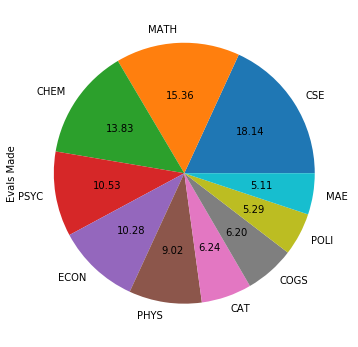

In [144]:
perDept('Evals Made',0,10).plot.pie(figsize=(6, 6),autopct='%.2f')

RMP

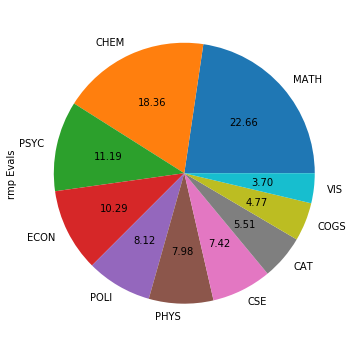

In [145]:
perDept('rmp Evals',0,10).plot.pie(figsize=(6, 6),autopct='%.2f')

#### Let's check out the grade distributions of each department  

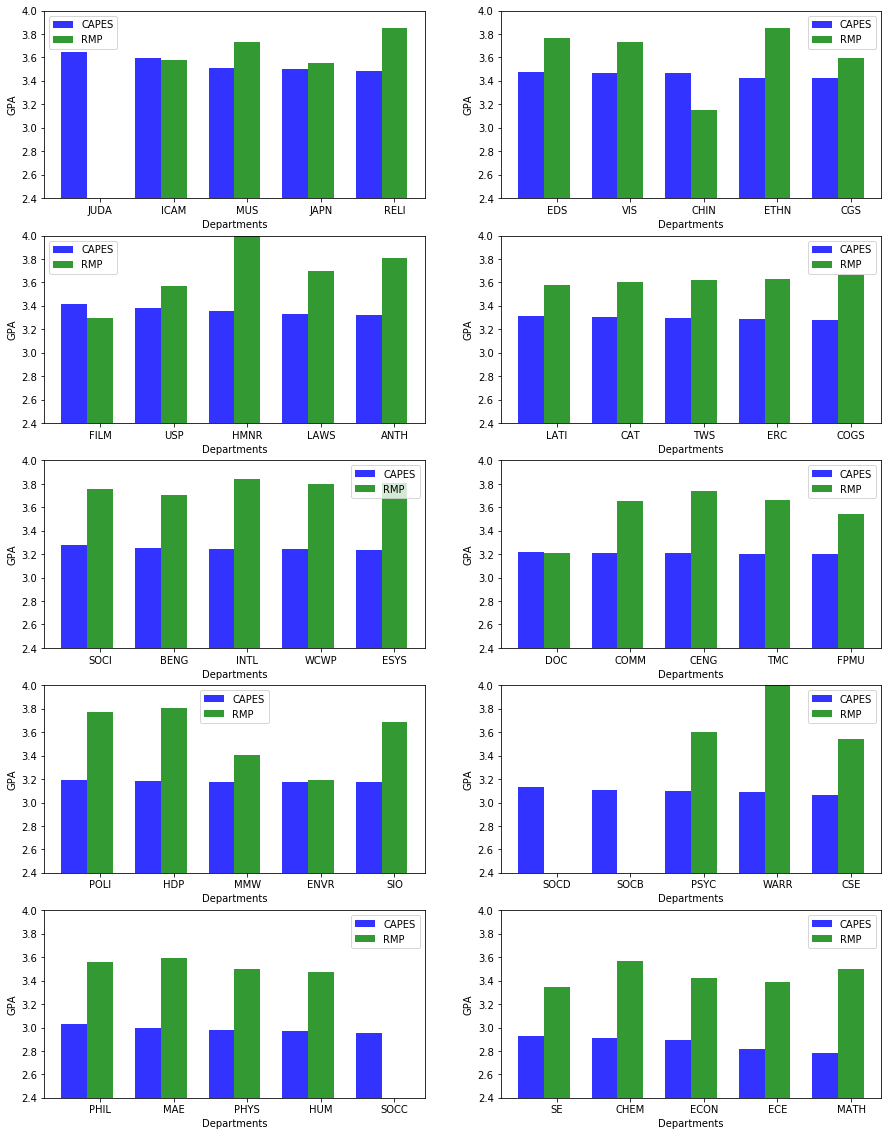

In [151]:
cape_g = perDept('Avg Grade Received',0,52,0).dropna()
rmp_g  = perDept('rmp Grade',0,52,0).dropna()

plt.figure(figsize=(15,20))
for i in range(0, 10):
    start = 5*i
    end = 5*(i+1)
    depts = cape_g[start:end].index.values
    rmp_vals = []
    for d in depts:
        if d in rmp_g:
            rmp_vals.append(rmp_g[d])
        else:
            rmp_vals.append(0)
       

    plt.subplot(5,2,i+1)
    #plt.bar(cape_g.index.values,cape_g.values,color=colors[i])

    n_groups = len(depts)
    capes = cape_g.values[start:end]
    rmp = rmp_vals[0:5]

    # create plot
    #fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, capes, bar_width,
    alpha=opacity,
    color='b',
    label='CAPES')

    rects2 = plt.bar(index + bar_width, rmp, bar_width,
    alpha=opacity,
    color='g',
    label='RMP')

    plt.xlabel('Departments')
    plt.ylabel('GPA')
    plt.ylim([2.4,4.0])
    #plt.title('GPA by Department')
    plt.xticks(index + bar_width, depts)
    plt.legend()

An interesting observation is that in almost every case RMP grades are higher than CAPE grades. To further investigate this we need to see if there are confounding variables such as evals made and enrollment size per department. The best way to start finding these potential variables is through a correlation map, let's do that next.

Also shoutout STEM majors for the low average CAPE GPA's ;)

### Data Analysis
#### Let's check out the correlations of our dataframe

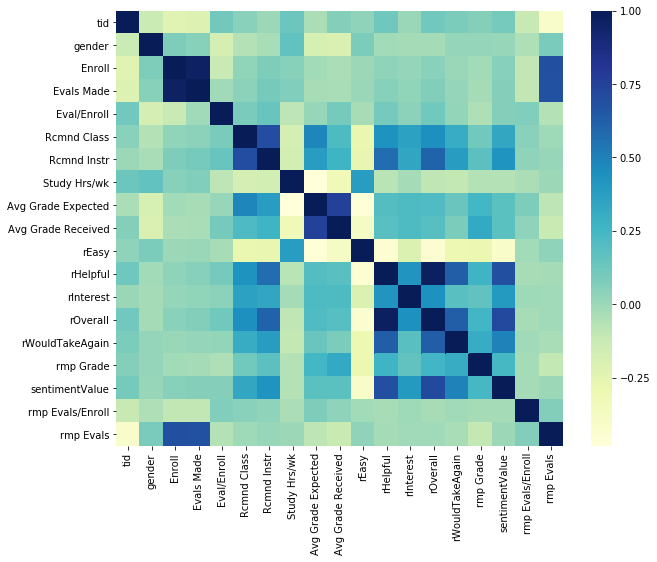

In [259]:
corr = df.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,cmap="YlGnBu")

In [7]:
df.corr()

,tid,gender,Enroll,Evals Made,Eval/Enroll,Rcmnd Class,Rcmnd Instr,Study Hrs/wk,Avg Grade Expected,Avg Grade Received,rEasy,rHelpful,rInterest,rOverall,rWouldTakeAgain,rmp Grade,sentimentValue,rmp Evals/Enroll,rmp Evals
tid,1.000000,-0.129969,-0.232904,-0.210577,0.111687,0.049902,0.002979,0.129561,-0.036380,0.060268,0.037959,0.125379,0.007734,0.111946,0.080514,0.059566,0.102918,-0.112000,-0.407429
gender,-0.129969,1.000000,0.076707,0.056548,-0.170810,-0.062053,-0.033922,0.165281,-0.183179,-0.199370,0.084450,-0.013839,-0.022267,-0.019895,0.021011,0.017764,0.013406,-0.047072,0.087384
Enroll,-0.232904,0.076707,1.000000,0.962362,-0.122624,0.031367,0.075923,0.055849,-0.017798,-0.038940,-0.000232,0.035394,0.017604,0.045297,0.008889,-0.016856,0.050951,-0.097676,0.694923
Evals Made,-0.210577,0.056548,0.962362,1.000000,-0.008201,0.042561,0.097648,0.072134,-0.026564,-0.031929,0.007035,0.055872,0.028976,0.065584,0.016913,-0.023986,0.062228,-0.098650,0.687240
Eval/Enroll,0.111687,-0.170810,-0.122624,-0.008201,1.000000,0.090976,0.148070,-0.083113,0.012929,0.099966,-0.026228,0.106564,0.039517,0.114512,0.022480,-0.043948,0.057528,0.069652,-0.060797
Rcmnd Class,0.049902,-0.062053,0.031367,0.042561,0.090976,1.000000,0.704146,-0.172225,0.479156,0.220397,-0.274066,0.433807,0.363769,0.446505,0.310476,0.117238,0.332233,0.048171,-0.006432
Rcmnd Instr,0.002979,-0.033922,0.075923,0.097648,0.148070,0.704146,1.000000,-0.165783,0.387957,0.265648,-0.271425,0.574478,0.344321,0.607265,0.382469,0.177171,0.432394,0.036813,0.014197
Study Hrs/wk,0.129561,0.165281,0.055849,0.072134,-0.083113,-0.172225,-0.165783,1.000000,-0.481607,-0.329627,0.382705,-0.074435,-0.019120,-0.088286,-0.101557,-0.064030,-0.061337,-0.040528,0.001269
Avg Grade Expected,-0.036380,-0.183179,-0.017798,-0.026564,0.012929,0.479156,0.387957,-0.481607,1.000000,0.755911,-0.468355,0.202476,0.219330,0.216509,0.140114,0.253154,0.183770,0.075593,-0.085510
Avg Grade Received,0.060268,-0.199370,-0.038940,-0.031929,0.099966,0.220397,0.265648,-0.329627,0.755911,1.000000,-0.382728,0.188697,0.222661,0.193057,0.083807,0.324910,0.181558,0.034780,-0.127583


In [260]:
# splits a dataframe into fourths by index
def split_4_df(df):
    numRows = len(df.index)
    l = [int(numRows*.25), int(numRows*.5), int(numRows*.75), numRows]
    l_mod = [0] + l + [max(l)+1]
    list_of_dfs = [df_sorted.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)]
    list_of_dfs.pop(4)
    return list_of_dfs

In [261]:
# splits a dataframe into halves by index
def split_2_df(df):
    numRows = len(df.index)
    list_of_dfs = [None]*2
    list_of_dfs[0] = df[:int(numRows/2)]
    list_of_dfs[1] = df[int(numRows/2):]
    return list_of_dfs

In [10]:
# takes an array of values and a string, plots the distribution with the given string as the title and
#  calculates mean and normality
def plotNormal(data, str_in):
    alpha = 0.01
    xs = np.arange(data.min(), data.max(), 0.1)
    fit = stats.norm.pdf(xs, np.mean(data), np.std(data))
    plt.figure()
    plt.plot(xs, fit, label='Normal Dist.', lw=4)
    plt.hist(data, density=True, label='Actual Data');
    plt.title(str_in)
    plt.legend();
    print("mean: " + str(data.mean()))
    print(normaltest(data))
    s, p = normaltest(data)
    if(p > alpha):
        print("Distribution is Normal")
    else:
        print("Distribution is not Normal")

### Checking for normality of distribution in grades received
Here we check if there is a normal distribution for gpa's on CAPE's reviews for our overall sample in order to better interpret our data moving forward.

mean: 3.101323452740505
NormaltestResult(statistic=0.9026640466307667, pvalue=0.6367793814735785)
Distribution is Normal


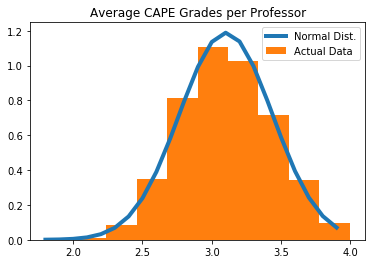

In [263]:
#checking for normal distribution for grades vs eval/enroll
avg_grades = df['Avg Grade Received'].dropna().values
plotNormal(avg_grades, "Average CAPE Grades per Professor")

Here we see that average grades received on CAPE's are distributed normally with a mean of 3.10

Now lets compare this to the distribution of reported grades on RateMyProfessor.

mean: 3.588047384237989
NormaltestResult(statistic=547.7802158140724, pvalue=1.1247020535099234e-119)
Distribution is not Normal


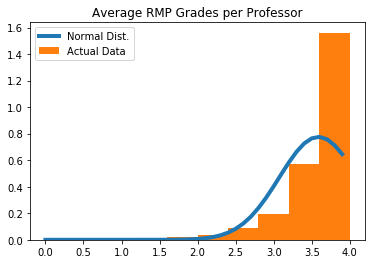

In [264]:
rmp_grades =  df['rmp Grade'].dropna().values
plotNormal(rmp_grades, "Average RMP Grades per Professor")


As you can see, the average grades reported for each professor on RMP does is NOT normally distributed and in fact skews left and has a mean GPA of 3.59. This data, when compared with the more accurate grade distributions from CAPE's, suggests that either students are more likely to post a review on RMP if they receive a higher grade from their professor, or that they are more likely to report their grade on RMP when recieving a higher grade (this is a possibility because reporting your grade on RMP is optional when posting a review). 

Either way, what we can conclude is that students are more likely to post a review with their grade on RMP when they receive a higher grade from their professor.

To learn more, we will check the mean and distribution of CAPE grades received for professors that have no reported grades on their RMP reviews. If it is the case that students are in fact more likely to report their grade on rmp when they recieve a higher grade in the class, we expect that this data would have a lower mean.

mean: 3.0955308207900663
NormaltestResult(statistic=0.548556018796085, pvalue=0.7601207251783423)
Distribution is Normal


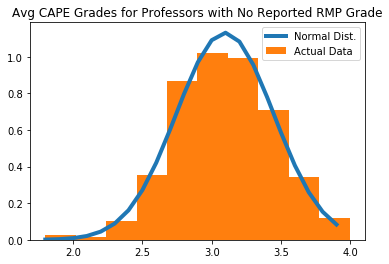

In [265]:
rmp_nan_grades = df[pd.isnull(df['rmp Grade'])]
rmp_nan_grades = rmp_nan_grades['Avg Grade Received'].dropna().values
plotNormal(rmp_nan_grades, "Avg CAPE Grades for Professors with No Reported RMP Grade")

We can see there is a normal distribution of grades with a mean of 3.10, demonstrating little difference compared to the mean and distribution of CAPE grades for all the professors. This shows that overall, a professor not having a single grade reported on RMP is independent of the average grades they give to students. Although not conclusive, the data seems to suggest that when reviewing a professor on RMP, students are not more nor less likely to report their grade depending on how well they did. However, more analysis is needed.

To further test whether students are more likely to make a review on RMP when they get a higher grade, we will check the distribution of CAPE grades given by professors split by their rmp-Evals/Enroll value, which represents the proportion a students a professor has had that made a review on RMP. We will check the mean/distribution of CAPE gpa to see any potential differences.

After splitting our data in two based on their proportion of RMP evaluations, we will check the mean and distribution of the CAPE grades and run a t-test to measure a significant difference, using an alpha of 0.01.

In [266]:
def checkSignificance(a, b):
    alpha = 0.01
    print(stats.ttest_ind(a, b, axis=None))
    s, p = stats.ttest_ind(a, b, axis=None)
    if(p < alpha):
        print("Difference is Significant")
        return True
    print("Difference is not Significant")
    return False

mean: 3.1399333832392786
NormaltestResult(statistic=5.009260294448031, pvalue=0.08170581151887374)
Distribution is Normal
mean: 3.0627669246352305
NormaltestResult(statistic=0.08949757970007181, pvalue=0.956237668271249)
Distribution is Normal
Ttest_indResult(statistic=4.3957165277768, pvalue=1.184893229152361e-05)
Difference is Significant


True

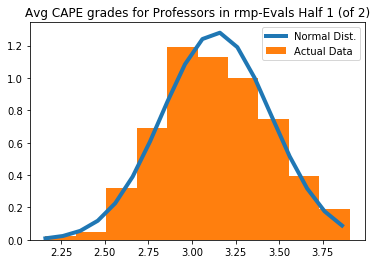

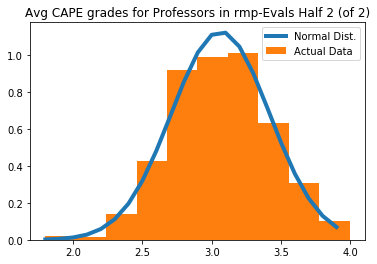

In [267]:
df_list2 = split_2_df(df.sort_values(by=['rmp Evals/Enroll']).dropna(subset=['Avg Grade Received']))
i = 0
#df_list2[1] = df_list2[1].drop(df_list2[1].index[len(df_list2[1])-1])
for d in df_list2:
    i = i + 1
    title = "Avg CAPE grades for Professors in rmp-Evals Half " + str(i) + " (of " + str(len(df_list2)) + ")"
    plotNormal(d['Avg Grade Received'].dropna().values, title)

checkSignificance(df_list2[0]['Avg Grade Received'].values, df_list2[1]['Avg Grade Received'].values)



The first Graph represents data for professors in the lower half of values for rmp-Evals/Enroll, and the second graph represents professors in the upper half. From the data we can see a difference in mean GPA and that the difference is statistically significant. The data shows a possibility that students with a lower GPA are more likely to post a reivew on RMP, but is not enough to allow us to conclude the average GPA given by a professor directly affects the proportion of students who post a review on RMP.

Now we will run an ordinary least squares regression model

In [270]:
df_ols = df[["Avg Grade Received", "rmp Evals/Enroll", 'tDept']].dropna()
outcome_1, predictors_1 = patsy.dmatrices('Q("rmp Evals/Enroll") ~ Q("Avg Grade Received")', df_ols)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                              OLS Regression Results                             
Dep. Variable:     Q("rmp Evals/Enroll")   R-squared:                       0.001
Model:                               OLS   Adj. R-squared:                  0.001
Method:                    Least Squares   F-statistic:                     1.748
Date:                   Sun, 17 Mar 2019   Prob (F-statistic):              0.186
Time:                           02:37:21   Log-Likelihood:                 2237.2
No. Observations:                   1445   AIC:                            -4470.
Df Residuals:                       1443   BIC:                            -4460.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

Using an alpha of 0.05, the data does not support the idea that GPA influences the proportion of rmp evals for a professor.

### Gender Grade Analysis

Let's grab the number of men and women professors per department

In [279]:
avg_overall_men = {}
avg_overall_women = {}

depts = df['tDept'].unique()
for d in depts:
    avg_overall_men[d] = len(df[(df['tDept'] == d) & (df['gender'] == 1)])
    avg_overall_women[d] = len(df[(df['tDept'] == d) & (df['gender'] == -1)])
    
women_profs = pd.Series(avg_overall_women)
men_profs = pd.Series(avg_overall_men)

And proportion of men to women per department

In [280]:
wm_ratio = men_profs / women_profs
wm_ratio = wm_ratio.dropna()
wm_ratio = wm_ratio.drop(wm_ratio[wm_ratio == np.inf].index)

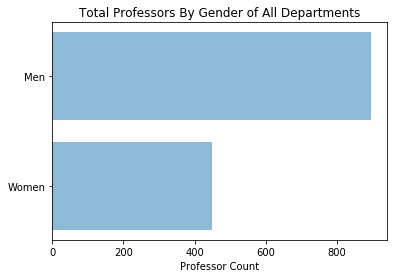

In [281]:
objects = ('Women','Men')
y_pos = np.arange(len(objects))
profs = [women_profs.sum(),men_profs.sum()]

plt.barh(y_pos, profs, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Professor Count')
plt.title('Total Professors By Gender of All Departments')
 
plt.show()

We can observe there are about twice as many men professor's as there are women!

Now let's see the ratio of men to women for each department

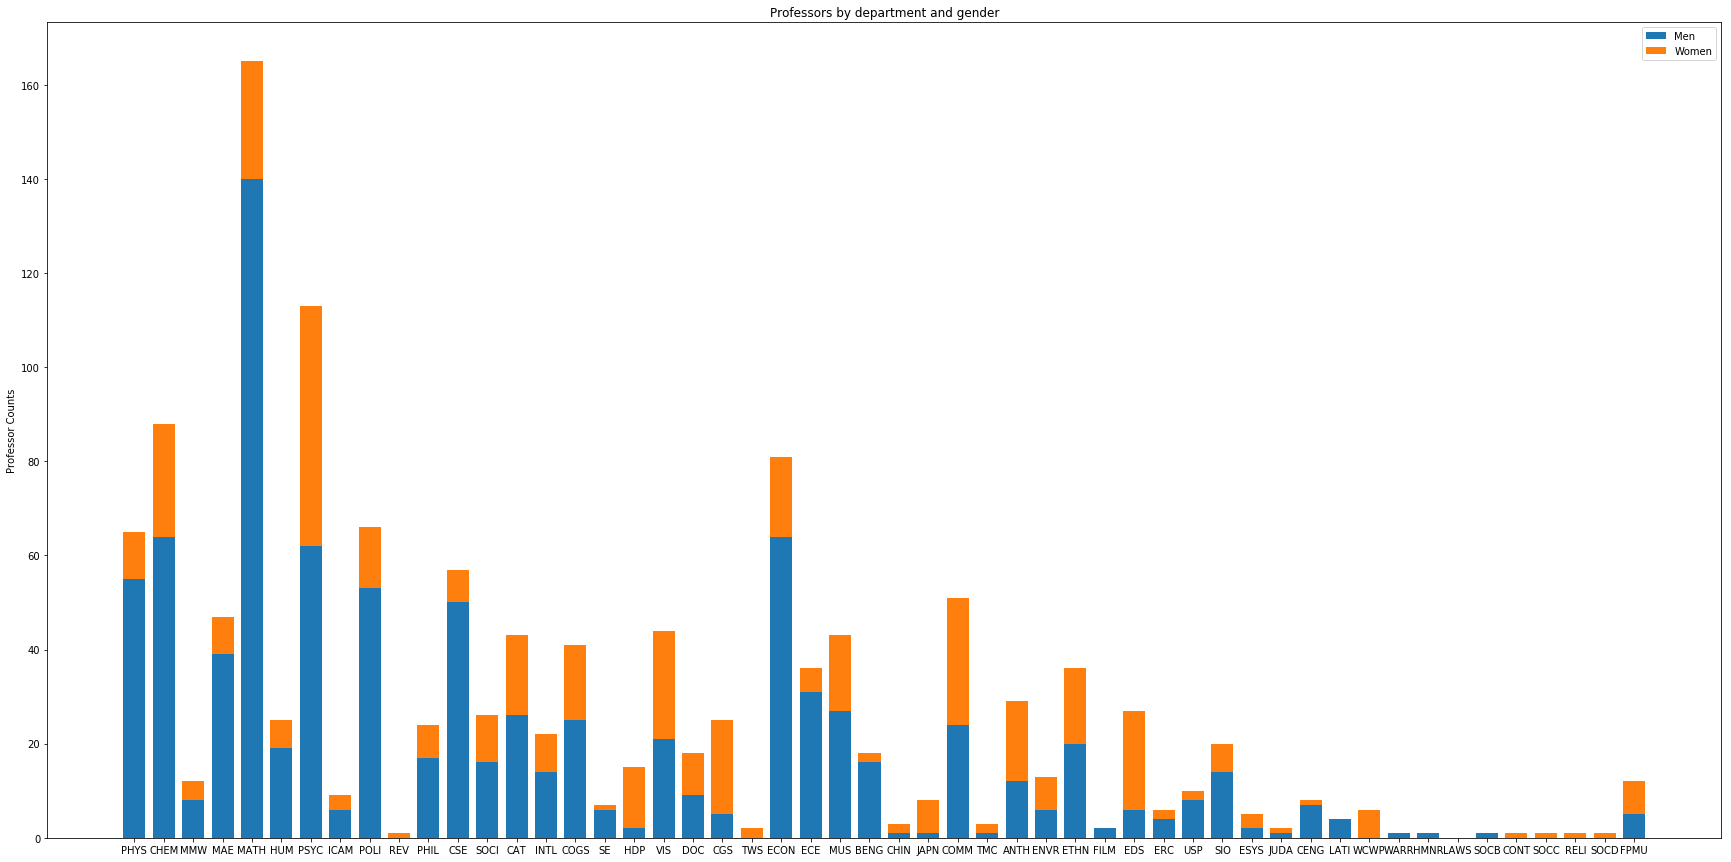

In [282]:
N = len(men_profs)
menMeans = men_profs
womenMeans = women_profs
ind = np.arange(N)    
width = 0.75

plt.figure(figsize=(30,15))
p1 = plt.bar(ind, menMeans, width)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans)

plt.ylabel('Professor Counts')
plt.title('Professors by department and gender')
plt.xticks(ind, men_profs.index.values)
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))


plt.show() 

** Note that this is not representative of total professor for deparment because genders with nan values were removed

Text(0.5, 1.0, 'Ratio of Men to Women for Each Department')

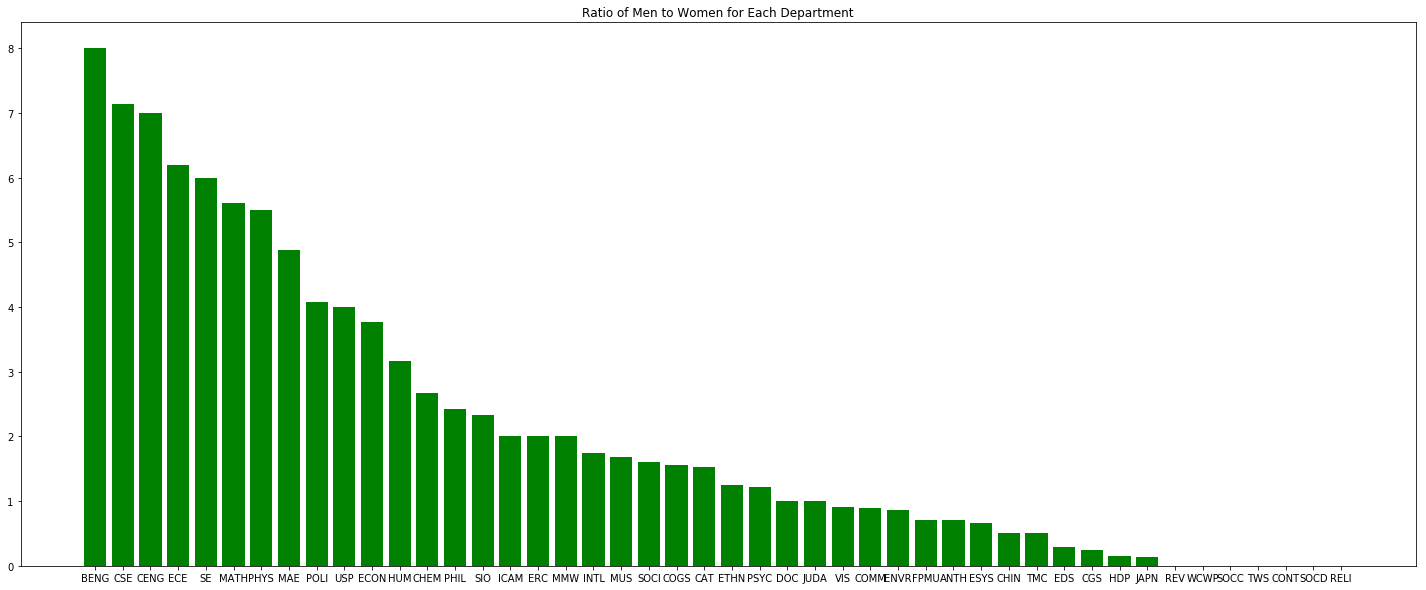

In [285]:
wm_ratio = wm_ratio.sort_values(ascending=False)
plt.figure(figsize=(25,10))
barlist = plt.bar(wm_ratio.index.values,(wm_ratio.values),color='g')
plt.title('Ratio of Men to Women for Each Department')

Here we notice a strong bias towards men in STEM departments

### Now let's look at average grades recieved for each department by gender

The function grabs all of the features per gender per department, and optionally returns only the departments that have both men and women professors teaching.

In [290]:
def genderColumn(col,nonans):
    avgg_men = {}
    avgg_women = {}
    depts_unused = {"M":[],"W":[]}
    for d in depts:
        menv = df[(df['tDept'] == d) & (df['gender'] == 1)][col].mean()
        womenv = df[(df['tDept'] == d) & (df['gender'] == -1)][col].mean()
        if(nonans):
            if(pd.notnull(menv) and pd.notnull(womenv)):
                avgg_men[d] = df[(df['tDept'] == d) & (df['gender'] == 1)]['Avg Grade Received'].mean()
                avgg_women[d] = df[(df['tDept'] == d) & (df['gender'] == -1)]['Avg Grade Received'].mean()  
            else:
                if(pd.notnull(menv)):
                    depts_unused["W"].append(d)
                elif(pd.notnull(womenv)):
                    depts_unused["M"].append(d)
                    
        else:
            avgg_men[d] = menv
            avgg_women[d] = womenv
    

        
    ms = pd.Series(avgg_men).dropna().sort_values(ascending=False)
    ws = pd.Series(avgg_women).dropna().sort_values(ascending=False)
    return ms, ws, depts_unused

In [291]:
avgg_men, avgg_women, depts_unused = genderColumn('Avg Grade Received',False)
avgg_rmp_men, avgg_rmp_women, depts_unused = genderColumn('rmp Grade',False)

In [292]:
wmg = pd.DataFrame([['M',avgg_rmp_men.values.mean(),avgg_men.values.mean()],['F',avgg_rmp_women.values.mean(),avgg_women.values.mean()]],
             columns=['Gender','RMP grades','CAPE grades'])
wmg

,Gender,RMP grades,CAPE grades
0,M,3.669435,3.202956
1,F,3.553537,3.207296


It's interesting to notice that the average grades given on CAPES between genders very close, to the 0.001 degree, however, grades reported on RMP across genders differs by approximately 0.12 points, favoring male professors.

### Let's Check if The Distributions are Normal

In [293]:
def plotNormal2(data,title):
    xs = np.arange(data.min(), data.max(), 0.1)
    fit = stats.norm.pdf(xs, np.mean(data), np.std(data))

    plt.plot(xs, fit, label='Normal Dist.', lw=4)
    plt.hist(data, density=True, label='Actual Data');
    plt.title(title)
    plt.legend();

In [296]:
def computeGenderGradePlots():
    plt.figure(figsize=(15,10))
    plt.subplot(2, 2, 1)
    plotNormal2(avgg_men,"Men Cape Grades")
    s,p =normaltest(avgg_men)
    plt.xlabel('p-value: ' + str(p))

    plt.subplots_adjust(wspace = 0.5)
    plt.subplots_adjust(hspace = 0.5)

    plt.subplot(2, 2, 2)
    plotNormal2(avgg_rmp_men,"Men RMP Grades")
    s,p =normaltest(avgg_rmp_men)
    plt.xlabel('p-value: ' + str(p))()

    plt.subplot(2, 2, 3)
    plotNormal2(avgg_women,"Women Cape Grades")
    s,p =normaltest(avgg_women)
    plt.xlabel('p-value: ' + str(p))


    plt.subplot(2, 2, 4)
    plotNormal2(avgg_rmp_women,"Women RMP Grades")
    s,p =normaltest(avgg_rmp_women)
    plt.xlabel('p-value: ' + str(p))

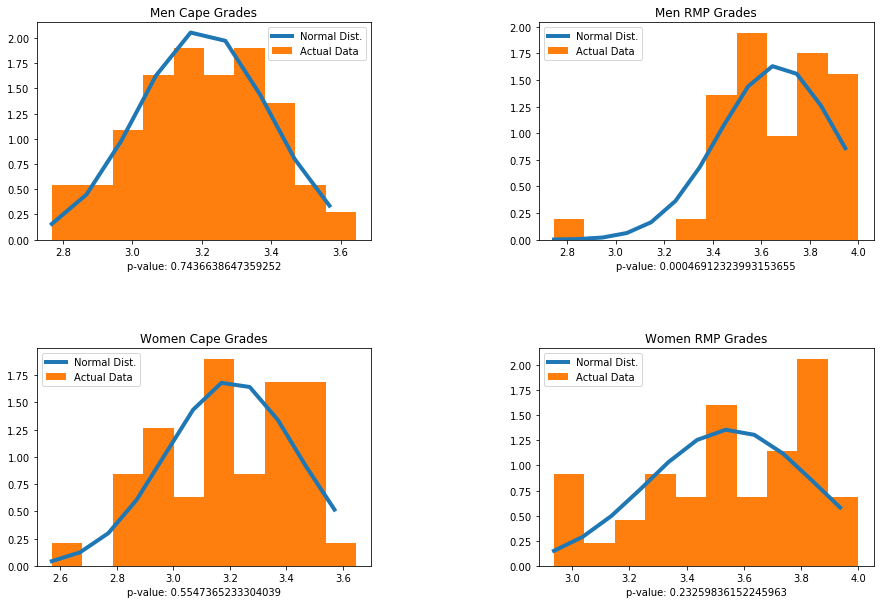

In [297]:
computeGenderGradePlots()

From the above distributions, we can see that the Men RMP Grades are not normally distributed but skewed left. This agrees with the above observation of men having a slightly higher reported GPA on RMP than Women

The above data contained departments that contained either no male nor female professors. Let's only look at departments that have both professors to see if there is any different in avergage GPA across genders

In [299]:
avgg_men, avgg_women, depts_unused = genderColumn('Avg Grade Received',True)
avgg_rmp_men, avgg_rmp_women, depts_unused_rmp = genderColumn('rmp Grade',True)

In [300]:
print("Departments w/o any men in Capes")
print(depts_unused["M"])
print("Departments w/o any women in Capes")
print(depts_unused["W"])
print()
print("Departments w/o any men in RMP")
print(depts_unused_rmp["M"])
print("Departments w/o any women in RMP")
print(depts_unused_rmp["W"])

Departments w/o any men in Capes
['TWS', 'TMC', 'JUDA', 'WCWP', 'SOCC', 'RELI', 'SOCD']
Departments w/o any women in Capes
['FILM', 'LATI', 'WARR', 'HMNR', 'SOCB']

Departments w/o any men in RMP
['REV', 'TWS', 'JAPN', 'WCWP', 'CONT', 'RELI']
Departments w/o any women in RMP
['SE', 'FILM', 'CENG', 'LATI', 'WARR', 'HMNR']


In [301]:
wmg = pd.DataFrame([['M',avgg_rmp_men.values.mean(),avgg_men.values.mean()],['F',avgg_rmp_women.values.mean(),avgg_women.values.mean()]],
             columns=['Gender','RMP grades','CAPE grades'])
wmg

,Gender,RMP grades,CAPE grades
0,M,3.198064,3.197116
1,F,3.207199,3.195767


From the above table we can see that when considering only departments with both genders, not only do the male and female RMP grades agree with each other, but all the GPA's fall within very close range of each other

Let's run normal distributions on this data once more

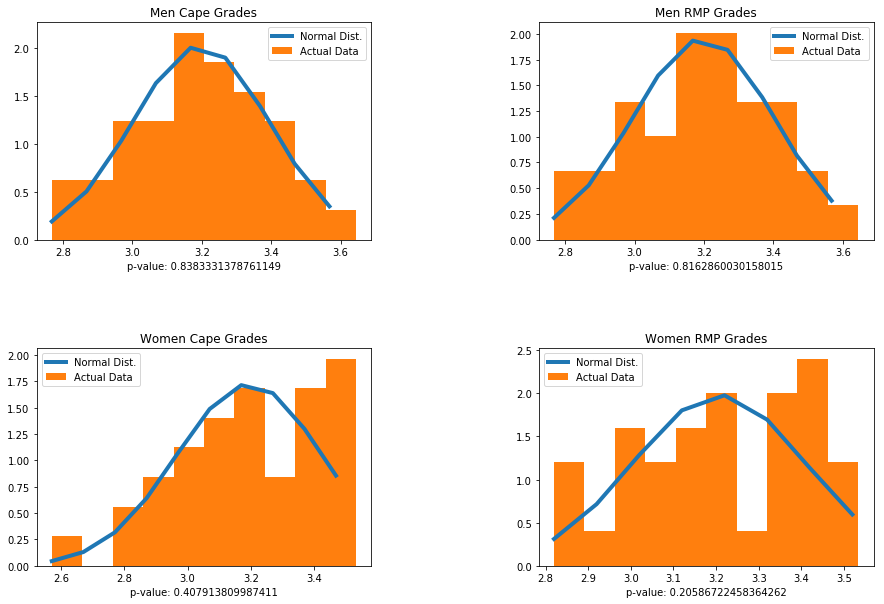

In [303]:
computeGenderGradePlots()

Let's check if there is a statistical difference in cape grades per gender

In [304]:
checkSignificance(avgg_men,avgg_women)

Ttest_indResult(statistic=0.026615876188426375, pvalue=0.9788397436352239)
Difference is not Significant


False

Let's now check if there is a statistical difference in RMP grades per gender

In [305]:
checkSignificance(avgg_rmp_men,avgg_rmp_women)

Ttest_indResult(statistic=-0.18439592824645284, pvalue=0.8542598558136969)
Difference is not Significant


False

### Further Gender Analysis

We will separate the professors by gender into two dataframes.

In [7]:
df_male = df[df['gender'] == 1]
df_female = df[df['gender'] == -1]

We want to check if there is a significant difference in sentiment values on RMP between male and female professors. To do this, we will first need to clean up the data and check for a normal distribution of sentiment values. To make the data more accurate, for this part, we will remove professors with an rmp-Evals/Enroll ratio that is greater than 1, as well as those with 3 or fewer reviews on RMP since too few reviews result in more extreme ratings as the averages are determined by only 1-3 reviewers, and these cases represent a very small portion of the data. In addition, we will run a Box Cox transformation on the sentiment values to normalize them, as they are skewed by their nature.

mean: 0.17707934113373192
NormaltestResult(statistic=4.330318143797531, pvalue=0.11473168255903078)
Distribution is Normal
mean: 0.17744344265304973
NormaltestResult(statistic=0.1568528302678875, pvalue=0.924570091794829)
Distribution is Normal


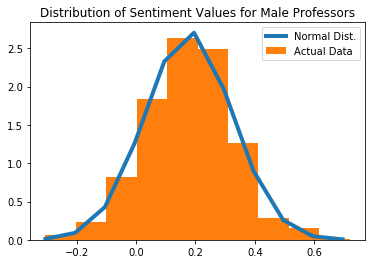

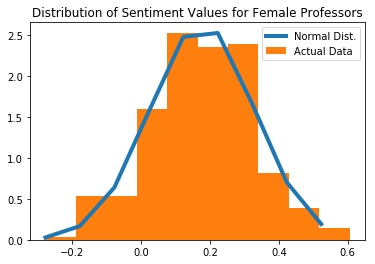

In [11]:
temp = df[df["rmp Evals/Enroll"] < 1]
temp = temp[temp["rmp Evals"] > 3]
df_male = temp[temp['gender'] == 1]
df_female = temp[temp['gender'] == -1]
sent_male = stats.boxcox(df_male["sentimentValue"].values + 1)[0]
sent_female = stats.boxcox(df_female["sentimentValue"].values + 1)[0]
plotNormal(sent_male,"Distribution of Sentiment Values for Male Professors")
plotNormal(sent_female, "Distribution of Sentiment Values for Female Professors")

We can see that the average sentiment value between male and female professors is very close. But is the difference statistically significant? Here we check by running a t-test with an alpha of 0.01.

In [310]:
checkSignificance(sent_male, sent_female)

Ttest_indResult(statistic=-0.036301909751724516, pvalue=0.9710488218691024)
Difference is not Significant


False

It seems that there is no significant difference in sentiment between the genders on RMP.

Finally, we will confirm this with a least squares regression using an alpha value of 0.05. Since their is no significant difference in grades given between male and female professors, we do not need to control for it.

In [17]:
temp['gender'] = temp['gender'].apply(lambda x: str(x))
outcome_1, predictors_1 = patsy.dmatrices('sentimentValue ~ gender', df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:         sentimentValue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2414
Date:                Thu, 21 Mar 2019   Prob (F-statistic):              0.623
Time:                        15:04:33   Log-Likelihood:                 583.19
No. Observations:                1345   AIC:                            -1162.
Df Residuals:                    1343   BIC:                            -1152.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1584      0.005     34.903      0.0

This further demonstrates no correlation between gender and sentiment value.

### Conclusion

In this project, we tried to determine whether there were any biases one way or the other in terms of reviews made on Rate My Professor. We checked for different aspects that could potentially result in bais towards or against a professor, such as GPA and gender.

In terms of gender, we checked for differences in gender biases on RMP by comparing their sentiment values. We checked for differences in GPA between professors to see if we needed to control for it in terms of sentiment value, and found no significant difference in terms of GPA. When we checked for differences in sentiment, we found no statistically significant difference between make and female professors. Thus, in terms of gender, we cannot reject the null hypothesis.

We also checked whether there was a bias in the number of reviews left on Rate My Professor. Afer controlling for things such as class size, we found little to no difference in which professors were more likely to have reviews written about them. One disparity we managed to find was between CAPE grades and RMP grades, with the data showing that students are more likely to report a higher grade when making a RMP review, and in that sense there seems to be a bias. However, we could not determine whether this was a bias in reporting a grade when making a review, or the likeyhood of making a review at all based on grade recieved. While we did find a slight difference when comparing the GPA for proffessors in the lower half of reviews written vs upper half of reviews written, we do not think that data alone is enough to reject the null hypothesis.

Overall, we could not find a definitive bias in terms of the circumstances of RMP reviews being made. That being said, we acknowledge that this study is by no means all-encompassing on the matter due to the limitations mentioned in the introduction. In the scope of this study, we cannot reject the null hypothesis.